## Шаг 1. Изучение исходных данных

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats as st

In [2]:
games_data = pd.read_csv('/datasets/games.csv')
print(games_data.info())
games_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB
None


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


<u>Пустые данные:</u>
- У двух игр нет названия. Можно дропнуть эти строки;
- Около 250 строк не имеют года выпуска
- Для двух игр не указан жанр;
- Для половины строк не заполнено значение critic_score;
- Около 6700 игр не имеют user_score и rating.

В пустые года выхода подставляем значения годов для других платформ (как правило, игры выходят одновременно). Отсутствие значения рейтингов позволяет предположить, что у игры нет оценок. В таком случае можно заменить значения на 0, это будет отдельная категория рейтинга.



## Шаг 2. Преобразование данных.
- Все названия столбцов преобразуются к нижнему регистру;
- year_of_release - заполнить пропуски по играм, в ненайденных подставить 0 и преобразовать в тип datetime. Год может отсутствовать, т.к. нет данных в источнике либо игра не выходила на определённой платформе. В данном случае можно подставить значения выхода на других платформах, т.к. как правило, игры выходят одновременно везде.
- na_sales, eu_sales, jp_sales и other_sales - подставить 0 в пропуски и округлить до 2 знаков. Здесь либо нет данных по продажам (игра не выходила на определённый рынок), либо продажи малы.
- critic_score - заполнить пропуски нулями и округлить до 1 знака после запятой. Мы не можем рассчитать оценки, поэтому подставим 0. Это позволит в будущем работать с отдельной категорией игр, у которых нет оценки.
- user_score - аналогично critic_score, подставить 0 и округлить до 1 знака. В столбце есть значения tbd. Их меняем на NaN и тоже подставляем 0, т.к. мы не можем рассчитать отсутствующие значения.
- rating - мы не можем рассчитать рейтинг по жанрам, т.к. внутри каждого жанра очень большой разброс (в каждом жанре есть игры разных рейтингов). Поэтому подставим 0 и в дальнейшем будем рассматривать эту категорию отдельно. Произойти так могло потому, что возрастные рейтинги стали присваиваться с определённого года, и старые игры остались без рейтинга.

In [3]:
<div style="border:solid green 2px; padding: 20px"> <h1 style="color:green; margin-bottom:20px">Комментарий наставника</h1>
    
Отличное начало, радует,что проводишь первичный анализ полученных данных и пишешь выводы#переводим названия столбоцв в нижний регистр
games_data.columns = games_data.columns.str.lower()
#убираем 2 игры без названия
games_data = games_data.dropna(subset=['name'])

#заполняем пропуски по году: составляем список игр, где год указан, выделяем год и проставляем его в исходной таблице.
not_null_year = games_data.loc[games_data['year_of_release'].notnull()]
game_list = not_null_year['name'].unique()

for game in game_list:
    release_year = not_null_year.loc[not_null_year['name'] == game].iloc[0]['year_of_release']
    games_data.loc[games_data['name'] == game, 'year_of_release'] = release_year

games_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16713 non-null object
year_of_release    16567 non-null float64
genre              16713 non-null object
na_sales           16713 non-null float64
eu_sales           16713 non-null float64
jp_sales           16713 non-null float64
other_sales        16713 non-null float64
critic_score       8137 non-null float64
user_score         10014 non-null object
rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.5+ MB


In [4]:
#где не указан год, подставляем 0 и приводим к типу int
games_data['year_of_release'] = games_data['year_of_release'].fillna(1900) #1900 - это 0 в годах
games_data['year_of_release'] = pd.to_datetime(games_data['year_of_release'], format='%Y')

In [5]:
#заполняем остальные пропуски и преобразуем типы данных
games_data[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']] = (
    games_data[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].round(2))
games_data.loc[games_data['user_score']== 'tbd', 'user_score'] = 0
games_data[['critic_score', 'user_score']] = games_data[['critic_score', 'user_score']].fillna(0).astype('float').round(1)
games_data['rating'] = games_data['rating'].fillna(0)

In [6]:
#смотрим информацию об обновленном датафрейме
print(games_data.info())
games_data.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16713 non-null object
year_of_release    16713 non-null datetime64[ns]
genre              16713 non-null object
na_sales           16713 non-null float64
eu_sales           16713 non-null float64
jp_sales           16713 non-null float64
other_sales        16713 non-null float64
critic_score       16713 non-null float64
user_score         16713 non-null float64
rating             16713 non-null object
dtypes: datetime64[ns](1), float64(6), object(4)
memory usage: 1.5+ MB
None


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006-01-01,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E
1,Super Mario Bros.,NES,1985-01-01,Platform,29.08,3.58,6.81,0.77,0.0,0.0,0
2,Mario Kart Wii,Wii,2008-01-01,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009-01-01,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E
4,Pokemon Red/Pokemon Blue,GB,1996-01-01,Role-Playing,11.27,8.89,10.22,1.00,0.0,0.0,0
5,Tetris,GB,1989-01-01,Puzzle,23.20,2.26,4.22,0.58,0.0,0.0,0
6,New Super Mario Bros.,DS,2006-01-01,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006-01-01,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009-01-01,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984-01-01,Shooter,26.93,0.63,0.28,0.47,0.0,0.0,0


In [7]:
#суммарные продажи в регионах
games_data['total_sales'] = games_data['na_sales'] + games_data['eu_sales'] + (
    games_data['jp_sales'] + games_data['other_sales'])

## Шаг 3. Исследовательский анализ данных.

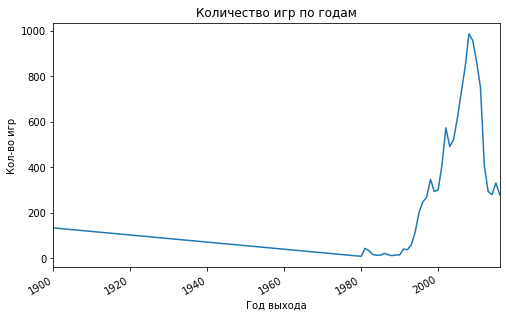

In [8]:
#выводим статистику по годам
games_per_year = (games_data[['name', 'year_of_release']]
                  .drop_duplicates()
                  .pivot_table(index='year_of_release', values='name', aggfunc='count')
                  .sort_values(by='year_of_release', ascending=True)
                 )
(games_per_year.plot(figsize=(8, 5), title='Количество игр по годам', legend=False)
 .set(xlabel = 'Год выхода', ylabel = 'Кол-во игр'))
plt.show()

На графике виден быстрый рост с 1995 года по 2010 и затем падение. Имеет смысл смотреть данные начиная с 2010 года.

In [9]:
#динамика продаж по платформам
sales_per_platform = (games_data[['platform','year_of_release', 'total_sales']]
                      .drop_duplicates()
                      .pivot_table(index='platform', values='total_sales', aggfunc='sum')
                      .sort_values(by='total_sales', ascending=False))
sales_per_platform

,total_sales
platform,
PS2,1029.07
X360,892.50
PS3,846.36
Wii,795.90
DS,646.88
PS,615.39
PS4,300.57
GB,254.97
GBA,254.19


<function matplotlib.pyplot.show(*args, **kw)>

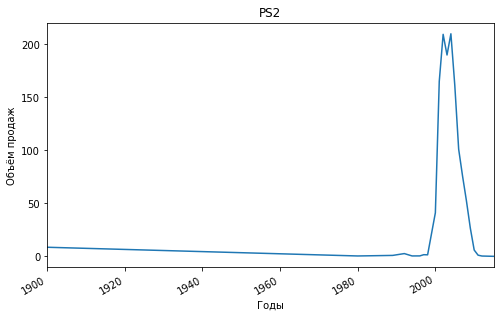

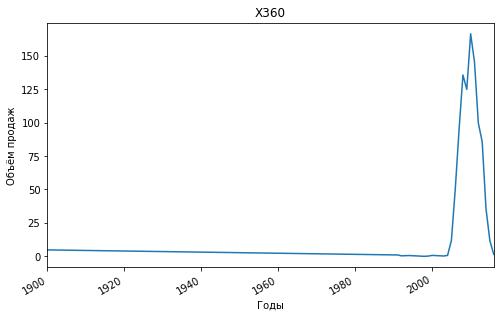

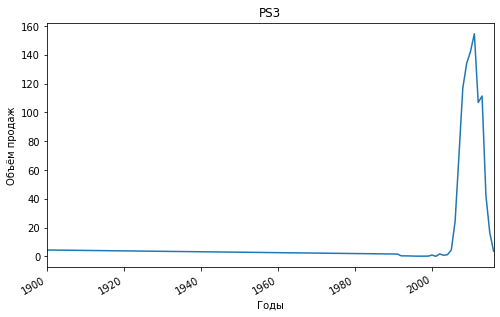

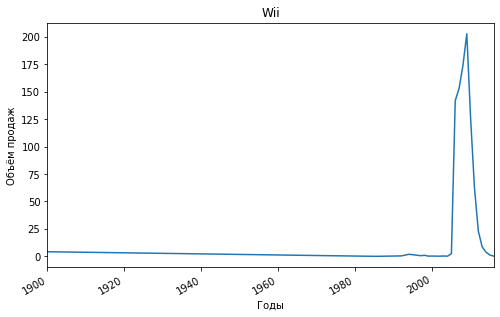

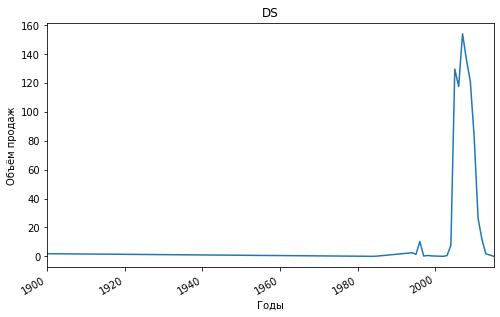

In [10]:
sales_top_platforms = sales_per_platform.head(5) #посмотрим на топ-5 кассовых платформ
for platform in sales_top_platforms.index:
    (games_data.loc[games_data['platform'] == platform]
     .pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')
        .plot(figsize=(8, 5), title = platform, legend=False)
    .set(xlabel = 'Годы', ylabel = 'Объём продаж'))
plt.show

Можно сделать вывод, что платформа в среднем живёт около 10 лет, причём пик объёма продаж приходится на середину этого срока. Если взять данные с 2010 года, то в 2016 году как раз должен быть пик актуальных платформ. С этими данными и будем работать.

In [11]:
#отбираем данные с 2010 года
actual_data = games_data.loc[games_data['year_of_release'] >= '2010-01-01']
print(actual_data.info())
actual_data.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5245 entries, 14 to 16714
Data columns (total 12 columns):
name               5245 non-null object
platform           5245 non-null object
year_of_release    5245 non-null datetime64[ns]
genre              5245 non-null object
na_sales           5245 non-null float64
eu_sales           5245 non-null float64
jp_sales           5245 non-null float64
other_sales        5245 non-null float64
critic_score       5245 non-null float64
user_score         5245 non-null float64
rating             5245 non-null object
total_sales        5245 non-null float64
dtypes: datetime64[ns](1), float64(7), object(4)
memory usage: 532.7+ KB
None


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
14,Kinect Adventures!,X360,2010-01-01,Misc,15.00,4.89,0.24,1.69,61.0,6.3,E,21.82
16,Grand Theft Auto V,PS3,2013-01-01,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
23,Grand Theft Auto V,X360,2013-01-01,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
27,Pokemon Black/Pokemon White,DS,2010-01-01,Role-Playing,5.51,3.17,5.65,0.80,0.0,0.0,0,15.13
29,Call of Duty: Modern Warfare 3,X360,2011-01-01,Shooter,9.04,4.24,0.13,1.32,88.0,3.4,M,14.73
31,Call of Duty: Black Ops 3,PS4,2015-01-01,Shooter,6.03,5.86,0.36,2.38,0.0,0.0,0,14.63
32,Call of Duty: Black Ops,X360,2010-01-01,Shooter,9.70,3.68,0.11,1.13,87.0,6.3,M,14.62
33,Pokemon X/Pokemon Y,3DS,2013-01-01,Role-Playing,5.28,4.19,4.35,0.78,0.0,0.0,0,14.60
34,Call of Duty: Black Ops II,PS3,2012-01-01,Shooter,4.99,5.73,0.65,2.42,83.0,5.3,M,13.79
35,Call of Duty: Black Ops II,X360,2012-01-01,Shooter,8.25,4.24,0.07,1.12,83.0,4.8,M,13.68


In [12]:
#смотрим динамику по годам для актуальных платформ
actual_data_pt = (actual_data.pivot_table(index='platform', columns='year_of_release', 
                                         values='total_sales', aggfunc='sum', margins=True)
                  .sort_values(by='All', ascending=False))
actual_data_pt.columns=[2010, 2011, 2012, 2013, 2014, 2015, 2016, 'All']

In [13]:
#отсеиваем платформы с продажами менее 100 млн
actual_data_pt = actual_data_pt.loc[actual_data_pt['All'] > 100]
actual_data_pt = actual_data_pt.drop(columns='All') #убираем итог, чтобы он не мешал на графике
actual_data_pt = actual_data_pt.drop(index='All')
actual_data_pt

,2010,2011,2012,2013,2014,2015,2016
platform,,,,,,,
PS3,142.30,154.59,106.88,111.38,42.45,16.55,3.60
X360,166.36,145.28,99.62,85.66,35.41,11.65,1.52
PS4,1.46,1.47,3.82,51.30,74.02,115.26,66.06
3DS,3.15,58.86,50.51,53.07,43.04,26.16,14.61
Wii,125.29,62.11,22.94,8.59,3.75,1.19,0.18
XOne,0.01,0.79,1.39,28.90,44.15,58.75,25.24
PC,26.61,34.34,23.27,14.08,12.51,8.46,5.06
DS,82.41,26.36,11.65,1.78,NaN,0.06,NaN


[Text(0, 0.5, 'Объём продаж, млн.$'), Text(0.5, 0, 'Годы')]

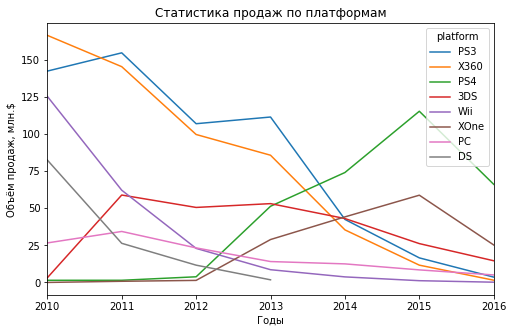

In [14]:
#строим графики
actual_data_pt = actual_data_pt.transpose() #транспонируем, чтобы нормально построился график
actual_data_pt.plot(figsize=(8, 5), 
                    title = ("Статистика продаж по платформам")).set(xlabel='Годы', ylabel='Объём продаж, млн.$')

На графике видно, что в 2016 году рынок игр просел по всем платформам. При этом наиболее прибыльными остаются PS4 и XOne, за ними идет 3DS. Рост PS4 и XOne начался в 2012 году, помня о 10-летнем цикле жизни модели, можно сказать, что эти платформы будут актуальны в ближайшее время. Что касается 3DS, её рост начался в 2011 году и в 2017 она всё ещё будет актуальна, но продажи у неё значительно ниже.

Исходя из вышеописанного, для дальнейшего анализа берём платформы PS4, XOne и 3DS.

In [15]:
#строим сводную таблицу по играм и платформам
games_sales_per_platform = games_data.pivot_table(index='name', columns='platform', values='total_sales', aggfunc='sum')
#отбираем актуальные платформы и сразу заполняем пропуски
games_actual_platforms = games_sales_per_platform[['PS4', 'XOne', '3DS']].fillna(0)
#games_actual_platforms = games_actual_platforms.fillna(0)

Теперь нам нужно посмотреть, на каких платформах игры продаются лучше. Для этого отбираем те игры, которые выходили на нескольких платформах одновременно.

In [16]:
games_actual_platforms = games_actual_platforms.query('PS4 > 0 & XOne > 0')
games_actual_platforms

platform,PS4,XOne,3DS
name,,,
7 Days to Die,0.14,0.05,0.00
Adventure Time: Finn & Jake Investigations,0.10,0.05,0.09
Agatha Christie's The ABC Murders,0.02,0.01,0.00
Alien: Isolation,1.12,0.50,0.00
Angry Birds Star Wars,0.22,0.17,0.33
...,...,...,...
Wolfenstein: The Old Blood,0.43,0.15,0.00
Worms: WMD,0.03,0.01,0.00
XCOM 2,0.14,0.04,0.00


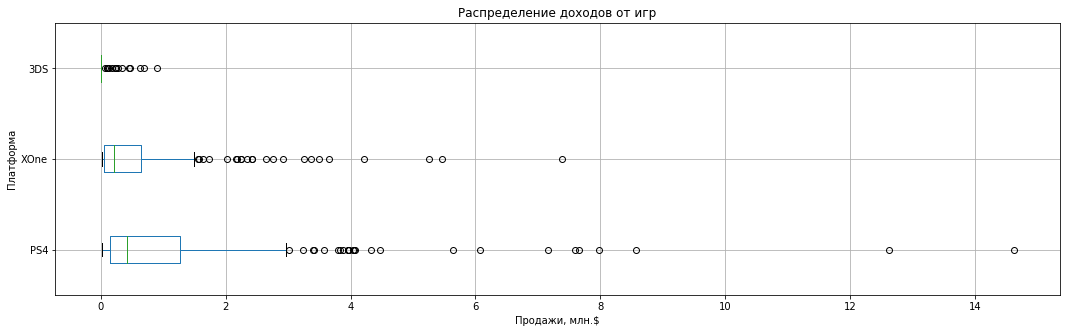

In [17]:
(games_actual_platforms.boxplot(figsize=(18, 5), vert=False)
    .set(title='Распределение доходов от игр', xlabel='Продажи, млн.$', ylabel='Платформа'))
plt.show()

В случае с 3DS кросс-платформенных проектов мало и доходность по ним ниже. Очевидно, что покупатели предпочитают XOne и PS4. У обеих этих платформ медиана доходности смещена влево. Это свидетельствует о том, что и там, и там достаточно много мелких игр. Однако "ящик" более растянут вправо в случае с PS4, это говорит о том, что там больше игр с высокой доходностью.

Таким образом, при планировании продаж имеет смысл сфокусироваться на играх, выпущенных в первую очередь для PS4 и XOne. Далее необходимо проверить, коррелируют ли продажи с отзывами критиков и пользователей. Проверять будем на PS4 как на самой прибыльной перспективной платформе.

In [18]:
#отбираем данные для построения диаграммы
scatter_data = games_data.query('platform == "PS4" & year_of_release >= "2010-01-01"')
scatter_data = scatter_data[['name', 'platform', 'year_of_release', 'critic_score', 'user_score', 'total_sales']]
scatter_data

,name,platform,year_of_release,critic_score,user_score,total_sales
31,Call of Duty: Black Ops 3,PS4,2015-01-01,0.0,0.0,14.63
42,Grand Theft Auto V,PS4,2013-01-01,97.0,8.3,12.62
77,FIFA 16,PS4,2015-01-01,82.0,4.3,8.58
87,Star Wars Battlefront (2015),PS4,2015-01-01,0.0,0.0,7.98
92,Call of Duty: Advanced Warfare,PS4,2014-01-01,83.0,5.7,7.66
...,...,...,...,...,...,...
16500,Root Letter,PS4,2016-01-01,69.0,7.5,0.01
16503,Shin Hayarigami 2,PS4,2016-01-01,0.0,0.0,0.01
16526,Dungeons 2,PS4,2016-01-01,61.0,7.9,0.01
16530,Carmageddon: Max Damage,PS4,2016-01-01,51.0,5.5,0.01


Из таблицы видно, что критики оценивают игру по 100-балльной шкале, а пользователи - по 10-балльной. Чтобы корректно отразить оценки на графике, приводим их к единому значению.

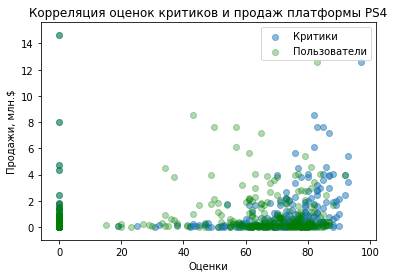

In [19]:
scatter_data['user_score_100'] = scatter_data['user_score'] * 10
scatter_critic = plt.scatter(scatter_data['critic_score'], scatter_data['total_sales'], alpha=0.5)
scatter_user = plt.scatter(scatter_data['user_score_100'], scatter_data['total_sales'], alpha=0.3, color='green')
plt.title('Корреляция оценок критиков и продаж платформы PS4')
plt.xlabel('Оценки')
plt.ylabel('Продажи, млн.$')
plt.legend((scatter_critic, scatter_user), ('Критики', 'Пользователи'), scatterpoints=1, loc='upper right')
plt.show()

В случае с оценками критиков всё закономерно - чем выше оценка, тем выше продажи. Что касается пользовательских оценок, не всё так однозначно. Достаточно много игр с хорошими оценками и низкими продажами, что объясняется большим количеством не очень популярных малобюджетных проектов. При этом для некоторых игр с высокими продажами и высокими оценками критиков пользовательские оценки находятся в районе 50. Это допустимо, т.к. не всегда пользователи сходятся во мнениях с критиками. В целом по графику можно говорить о наличии прямой корреляции между оценкой критиков и уровнем продаж.

Теперь проверим, работает ли такая корреляция для 2 других платформ.

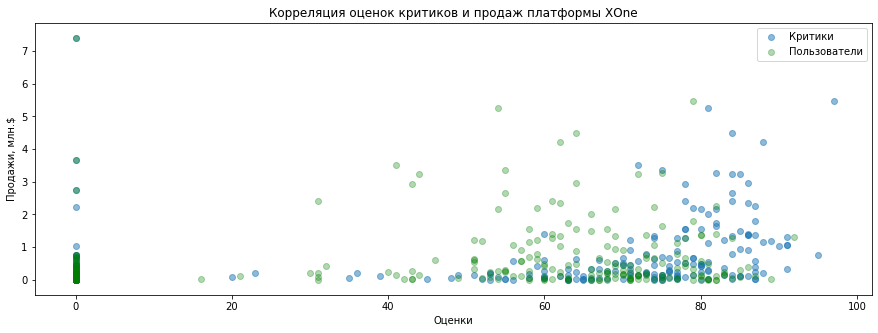

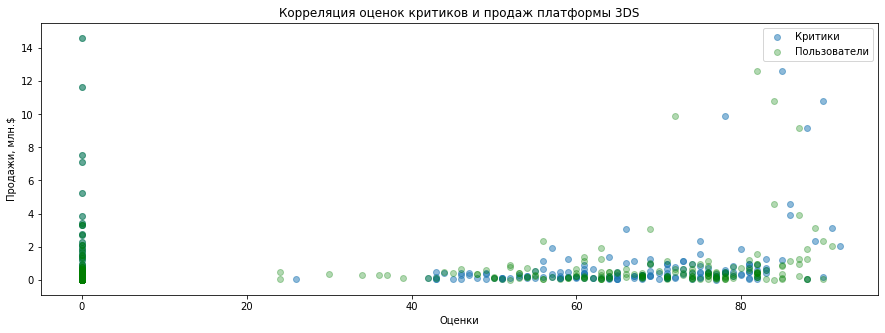

In [20]:
<div style="border:solid green 2px; padding: 20px"> <h1 style="color:green; margin-bottom:20px">Комментарий наставника</h1>

очень детально подходишь к работе, верные выводы, здорово!)#для XOne
scatter_data = games_data.query('platform == "XOne" & year_of_release >= "2010-01-01"')
scatter_data = scatter_data[['name', 'platform', 'year_of_release', 'critic_score', 'user_score', 'total_sales']]
scatter_data['user_score_100'] = scatter_data['user_score'] * 10
plt.figure(figsize=(15, 5))
scatter_critic = plt.scatter(scatter_data['critic_score'], scatter_data['total_sales'], alpha=0.5)
scatter_user = plt.scatter(scatter_data['user_score_100'], scatter_data['total_sales'], alpha=0.3, color='green')
plt.title('Корреляция оценок критиков и продаж платформы XOne')
plt.xlabel('Оценки')
plt.ylabel('Продажи, млн.$')
plt.legend((scatter_critic, scatter_user), ('Критики', 'Пользователи'), scatterpoints=1, loc='upper right')
plt.show()

#для 3DS
scatter_data = games_data.query('platform == "3DS" & year_of_release >= "2010-01-01"')
scatter_data = scatter_data[['name', 'platform', 'year_of_release', 'critic_score', 'user_score', 'total_sales']]
scatter_data['user_score_100'] = scatter_data['user_score'] * 10
plt.figure(figsize=(15, 5))
scatter_critic = plt.scatter(scatter_data['critic_score'], scatter_data['total_sales'], alpha=0.5)
scatter_user = plt.scatter(scatter_data['user_score_100'], scatter_data['total_sales'], alpha=0.3, color='green')
plt.title('Корреляция оценок критиков и продаж платформы 3DS')
plt.xlabel('Оценки')
plt.ylabel('Продажи, млн.$')
plt.legend((scatter_critic, scatter_user), ('Критики', 'Пользователи'), scatterpoints=1, loc='upper right')
plt.show()

Для XOne видно, что зависимость есть, причём пользователи чаще соглашаются в своих оценках с критиками. А вот на 3DS, несмотря на высокие оценки и критиков, и пользователей, продажи почти не растут. Исключение составляют буквально около 10 самых популярных игр. Можно сделать вывод, что 3DS является некой платформой для фанатов игр под неё.

Теперь посмотрим на распределение по жанрам.

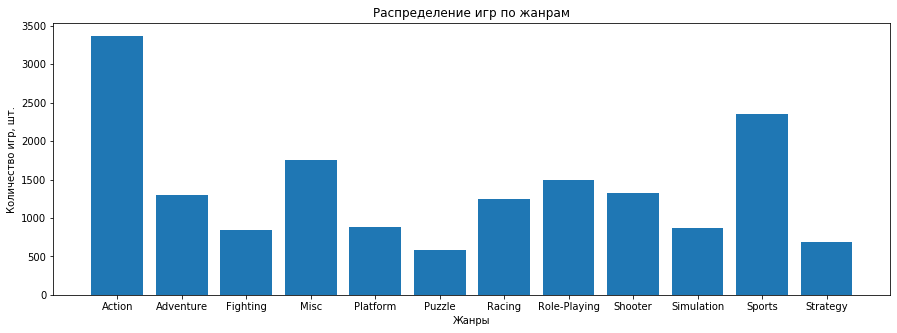

In [21]:
#распределение игр по жанрам
games_per_genre = games_data.pivot_table(index='genre', values='name', aggfunc='count')
plt.figure(figsize=(15, 5))
plt.bar(games_per_genre.index, games_per_genre['name'])
plt.title('Распределение игр по жанрам')
plt.xlabel('Жанры')
plt.ylabel('Количество игр, шт.')
plt.show()

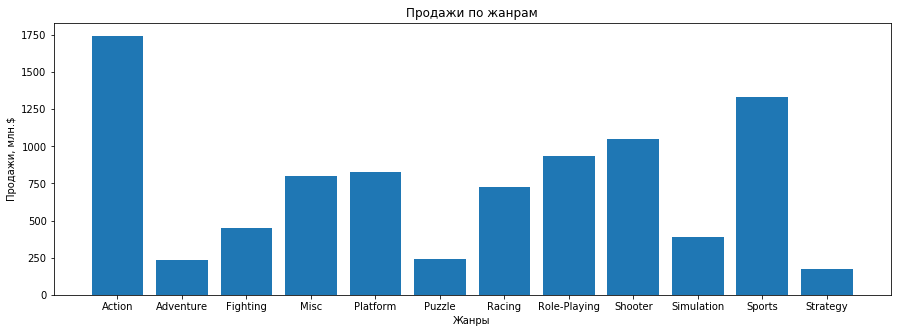

In [22]:
#продажи по жанрам
sales_per_genre = games_data.pivot_table(index='genre', values='total_sales', aggfunc='sum')
plt.figure(figsize=(15, 5))
plt.bar(sales_per_genre.index, sales_per_genre['total_sales'])
plt.title('Продажи по жанрам')
plt.xlabel('Жанры')
plt.ylabel('Продажи, млн.$')
plt.show()

<b>Вывод:</b> больше всего игр выходит в жанрах Action и Sports. При этом эти же жанры являются самыми продаваемыми, с небольшим отставанием идёт Shooter, и за ним все остальные. Наименее популярны Adventure, Fighting, Puzzle, Simulation и Strategy, при том что меньше всего игр в Puzzle и Strategy. Можно сделать вывод, что подобные жанры не особо интересны игрокам.

## Шаг 4. Портреты пользователей

Задача: определить для пользователя каждого региона (NA, EU, JP):
- Самые популярные платформы (топ-5). Описать различия в долях продаж.
- Самые популярные жанры (топ-5).
- Проверить, влияет ли рейтинг ESRB на продажи в отдельном регионе.

In [23]:
# рассчитываем рейтинг для каждой платформы

top_5_na_platforms = (games_data
                      .query('na_sales > 0 & year_of_release >= "2010-01-01"') #берём только актуальные продажи в NA регионе
                      .pivot_table(index='platform', values='na_sales', aggfunc='sum')
                      .sort_values(by='na_sales', ascending=False)
                      .head(5)
                     )
top_5_eu_platforms = (games_data
                      .query('eu_sales > 0 & year_of_release >= "2010-01-01"')
                      .pivot_table(index='platform', values='eu_sales', aggfunc='sum')
                      .sort_values(by='eu_sales', ascending=False)
                      .head(5)
                     )
top_5_jp_platforms = (games_data
                      .query('jp_sales > 0 & year_of_release >= "2010-01-01"')
                      .pivot_table(index='platform', values='jp_sales', aggfunc='sum')
                      .sort_values(by='jp_sales', ascending=False)
                      .head(5)
                     )

display(top_5_na_platforms, top_5_eu_platforms, top_5_jp_platforms)

,na_sales
platform,
X360,331.58
PS3,226.07
Wii,121.05
PS4,108.52
XOne,93.06


,eu_sales
platform,
PS3,210.00
X360,161.52
PS4,140.85
PC,70.07
Wii,66.06


,jp_sales
platform,
3DS,96.75
PS3,57.57
PSP,41.73
DS,28.16
PSV,21.38


<b>Выводы:</b>

1) в Северной Америке с большим отрывом лидирует X360. За ним идут PS3 и Wii, у современных PS4 и XOne доля относительно небольшая. Можно предположить, что пользователи не торопятся переходить на новое поколение консолей.

2) В Европе ситуация похожая: наибольшей популярностью пользуются PS3 и X360. Однако здесь набирает популярность PS4, также в топ-5 игровых платформ вошёл PC, предположительно из-за игроков из стран СНГ.

3) В Японии ожидаемо с большим отрывом лидирует 3DS, за ней идут продукты Sony. Японский рынок кардинально отличается от американского и европейского.

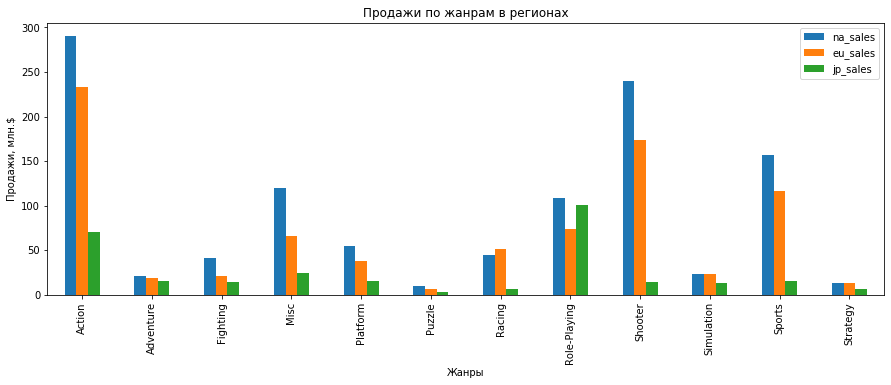

In [24]:
#делаем анализ по жанрам
genres_sales_na = (games_data
                   .query('year_of_release >= "2010-01-01"')
                   .pivot_table(index='genre', values='na_sales', aggfunc='sum')
                  )
genres_sales_eu = (games_data
                   .query('year_of_release >= "2010-01-01"')
                   .pivot_table(index='genre', values='eu_sales', aggfunc='sum')
                  )
genres_sales_jp = (games_data
                   .query('year_of_release >= "2010-01-01"')
                   .pivot_table(index='genre', values='jp_sales', aggfunc='sum')
                  )
genres_sales_total = genres_sales_na.merge(genres_sales_eu, left_index=True, right_index=True)
genres_sales_total = genres_sales_total.merge(genres_sales_jp, left_index=True, right_index=True)

genres_sales_total.plot(kind='bar', figsize=(15, 5))
plt.title('Продажи по жанрам в регионах')
plt.xlabel('Жанры')
plt.ylabel('Продажи, млн.$')
plt.show()

<b>Вывод:</b> В Америке и Европе наиболее популярны жанры Action и Shooter. В Японии ситуация иная: первое место там занимает жанр Role-Playing, и только за ним идёт Action.

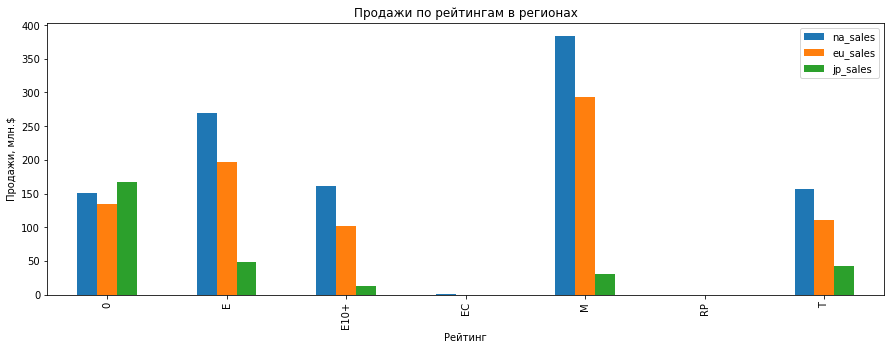

In [32]:
#делаем анализ по оценкам
rating_sales_na = (games_data
                   .query('year_of_release >= "2010-01-01"')
                   .pivot_table(index='rating', values='na_sales', aggfunc='sum')
                  )
rating_sales_eu = (games_data
                   .query('year_of_release >= "2010-01-01"')
                   .pivot_table(index='rating', values='eu_sales', aggfunc='sum')
                  )
rating_sales_jp = (games_data
                   .query('year_of_release >= "2010-01-01"')
                   .pivot_table(index='rating', values='jp_sales', aggfunc='sum')
                  )
rating_sales_total = rating_sales_na.merge(rating_sales_eu, left_index=True, right_index=True)
rating_sales_total = rating_sales_total.merge(rating_sales_jp, left_index=True, right_index=True)

rating_sales_total.plot(kind='bar', figsize=(15, 5))
plt.title('Продажи по рейтингам в регионах')
plt.xlabel('Рейтинг')
plt.ylabel('Продажи, млн.$')
plt.show()

<b>Вывод:</b> В Европе и Америке больше всего продаются игры с рейтингом М и Е. При этом в Японии у большинства игр нет рейтинга ESRB, можно сделать предположение, что в этой стране этот рейтинг не действует либо имеет информативный характер. Из рейтинговых игр в Японии больше всего продаются с рейтингом Е и Т, что подтверждает большое отличие японского рынка от европейского и американского. Однако возможно, что игр с этим рейтингом просто больше, чем остальных, здесь требуется дополнительное исследование.

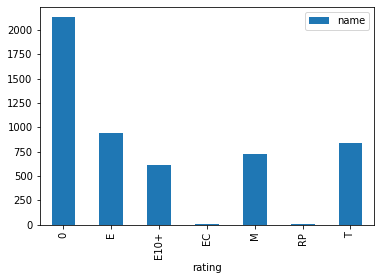

In [33]:
#количество игр по рейтингу
games_amount_rating = (games_data
                       .query('year_of_release >= "2010-01-01"')
                       .pivot_table(index='rating', values='name', aggfunc='count')
                      )
games_amount_rating.plot(kind='bar')

Как видно из диаграммы, больше всего игр без рейтинга. Вторые по массовости игры с рейтингом E и T, что полностью соответствует рейтингу продаж в Японии. За ними идут игры с рейтингом М и Т. Можно сказать, что продажи слабо зависят от рейтинга, т.к. если отбросить игры без оценки, наблюдается корреляция продаж с количеством игр по рейтингам.

## Шаг 5. Проверка гипотез

- Нулевая гипотеза: средние пользовательские рейтинги платформ Xbox One и РС одинаковые.
- Альтернативная гипотеза: средние пользовательские рейтинги платформ Xbox One и РС различаются.

In [34]:
xbox_user_ratings = games_data.query('platform == "XOne" & year_of_release >= "2010-01-01"') #берем актуальные данные
pc_user_ratings = games_data.query('platform == "PC" & year_of_release >= "2010-01-01"')

alpha = .05
results = st.ttest_ind(xbox_user_ratings['user_score'], pc_user_ratings['user_score'])
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.2151639019043931
Не получилось отвергнуть нулевую гипотезу


Средние рейтинги игроков на XOne и РС действительно равны. Теперь проверим вторую гипотезу.

- Нулевая гипотеза: средние пользовательские рейтинги жанров Action и Sports равны.
- Альтернативная гипотеза: Средние пользовательские рейтинги жанров Action и Sports разные.

In [35]:
action_user_ratings = games_data.query('genre == "Action" & year_of_release >= "2010-01-01"') #берем актуальные данные
sports_user_ratings = games_data.query('genre == "Sports" & year_of_release >= "2010-01-01"')

alpha = .05
results = st.ttest_ind(action_user_ratings['user_score'], sports_user_ratings['user_score'])
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.0475989846078626
Отвергаем нулевую гипотезу


Получается, что для жанров Action и Sports оценки пользователей разные.

## Общий вывод

1. Средний жизненный цикл наиболее популярных игровых платформ составляет 10 лет. Пик объёма продаж приходится на середину этого срока. Для анализа имеет смысл взять данные после 2010 года, в таком случае получится увидеть не только актуальные платформы, но также преспективные и уходящие.
---
2. В 2016 году наблюдается падение продаж игр на всех платформах. При этом наиболее прибыльными остаются PS4 и XOne, за ними идет 3DS. Рост PS4 и XOne начался в 2012 году, помня о 10-летнем цикле жизни модели, можно сказать, что эти платформы будут актуальны в ближайшее время. Что касается 3DS, её рост начался в 2011 году и в 2017 она всё ещё будет актуальна, но продажи у неё значительно ниже. Таким образом, для анализа целесообразно взять платформы PS4, XOne и 3DS.
---
3. В случае с 3DS кросс-платформенных проектов мало и доходность по ним ниже. Очевидно, что покупатели предпочитают XOne и PS4. У обеих этих платформ медиана доходности смещена влево. Это свидетельствует о том, что и там, и там достаточно много мелких игр. Однако на графике "ящик с усами" "ящик" более растянут вправо в случае с PS4, это говорит о том, что там больше игр с высокой доходностью. Таким образом, при планировании продаж имеет смысл сфокусироваться на играх, выпущенных в первую очередь для PS4 и XOne.
---
4. Для PS4 наблюдается прямая корреляция между оценками критиков и уровнем продаж. Что касается пользовательских оценок, не всё так однозначно. Достаточно много игр с хорошими оценками и низкими продажами, что объясняется большим количеством не очень популярных малобюджетных проектов. При этом для некоторых игр с высокими продажами и высокими оценками критиков пользовательские оценки находятся в районе 50. Это допустимо, т.к. не всегда пользователи сходятся во мнениях с критиками.
---
5. Для XOne видно, что зависимость продаж от оценок есть, причём пользователи чаще соглашаются в своих оценках с критиками. А вот на 3DS, несмотря на высокие оценки и критиков, и пользователей, продажи почти не растут. Исключение составляют около 10 самых популярных игр. Можно сделать вывод, что 3DS является некой платформой для фанатов игр под неё.
---
6. Больше всего игр выходит в жанрах Action и Sports. При этом эти же жанры являются самыми продаваемыми, с небольшим отставанием идёт Shooter, и за ним все остальные. Наименее популярны Adventure, Fighting, Puzzle, Simulation и Strategy, при том что меньше всего игр в Puzzle и Strategy. Можно сделать вывод, что подобные жанры не особо интересны игрокам.
---
7. Популярность разных игровых платформ зависит от рынка. В Северной Америке с большим отрывом лидирует X360. За ним идут PS3 и Wii, у современных PS4 и XOne доля относительно небольшая. Можно предположить, что пользователи не торопятся переходить на новое поколение консолей. В Европе ситуация похожая: наибольшей популярностью пользуются PS3 и X360. Однако здесь набирает популярность PS4, также в топ-5 игровых платформ вошёл PC, предположительно из-за игроков из стран СНГ. В Японии ожидаемо с большим отрывом лидирует 3DS, за ней идут продукты Sony. Японский рынок кардинально отличается от американского и европейского.
---
8. В Америке и Европе наиболее популярны жанры Action и Shooter. В Японии ситуация иная: первое место там занимает жанр Role-Playing, и только за ним идёт Action.
---
9. В Европе и Америке больше всего продаются игры с рейтингом М и Е. При этом в Японии у большинства игр нет рейтинга ESRB, можно сделать предположение, что в этой стране этот рейтинг не действует либо имеет информативный характер. Из рейтинговых игр в Японии больше всего продаются с рейтингом Е и Т, что подтверждает большое отличие японского рынка от европейского и американского. Однако возможно, что игр с этим рейтингом просто больше, чем остальных, здесь требуется дополнительное исследование.
---
10. В исходных данных больше всего игр без рейтинга. Вторые по массовости игры с рейтингом E и T, что полностью соответствует рейтингу продаж в Японии. За ними идут игры с рейтингом М и Т. Можно сказать, что продажи слабо зависят от рейтинга, т.к. если отбросить игры без оценки, наблюдается корреляция продаж с количеством игр по рейтингам.
---
11. В ходе анализа были проверены следующие гипотезы:
    - средние пользовательские рейтинги платформ Xbox One и РС одинаковые;
    - средние пользовательские рейтинги жанров Action и Sports равны.
    
    Анализ показал, что средние пользовательские рейтинги на РС и Xbox One действительно одинаковые, однако рейтинги жанров Action и Sports различаются. Возможно, средний рейтинг зависит от жанра. Для проверки этого предположения требуется дополнительный анализ.